## Attention Temporal Graph Convolutional Network (A3T-GCN)
Pretty sure this one is poorly implemented. <br />
The hidden state is never updated in the model and only the provided state is used. <br />
Unless the time series is processed one step at a time, this one is pretty useless. <br />
However, even then the model does not process anything temporally, it just accumulates node features sequentially.

### A3TGCN

100%|██████████| 200/200 [01:04<00:00,  3.11it/s]


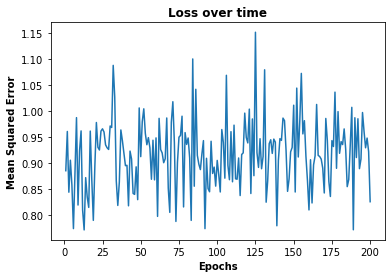

Train MSE: 0.8259
Test MSE: 0.9723


In [23]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

from torch_geometric.data import DataLoader

loader = ChickenpoxDatasetLoader()

lags = 10
stride = 1
epochs = 200
batch_size = 32

dataset = loader.get_dataset(lags)

sample = next(iter(dataset))
num_nodes = sample.x.size(0)
edge_index = sample.edge_index

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

train_loader = DataLoader(list(train_dataset), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(test_dataset), batch_size=batch_size, shuffle=False)

### MODEL DEFINITION
class AttentionGCN(nn.Module):
    def __init__(self):
        super(AttentionGCN, self).__init__()

        self.encoder = A3TGCN(1, 32, lags)
        self.decoder = nn.Linear(32, 1)

        # cached offsets for batch stacking for each batch_size
        self.batch_edge_offset_cache = {}

    def forward(self, window):
        
        x = window.x.unsqueeze(1)

        N = num_nodes
        B = x.size(0) // N

        num_edges = edge_index.size(1)
        try:
            batch_offset = self.batch_edge_offset_cache[(B, num_edges)]
        except:
            batch_offset = torch.arange(0, N * B, N).view(1, B, 1).expand(2, B, num_edges).flatten(1,-1)
            self.batch_edge_offset_cache[(B, num_edges)] = batch_offset
        # repeat edge indices B times and add i*num_nodes where i is the snapshot index
        batched_edge_index = edge_index.unsqueeze(1).expand(2, B, -1).flatten(1, -1) # repeated B times
        batched_edge_index += batch_offset
        
        h = self.encoder(x, batched_edge_index) # (batch, lags, num_nodes, 1)
        h = F.relu(h)

        pred = self.decoder(h).flatten()

        return pred
    
model = AttentionGCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

### TRAIN
model.train()

loss_history = []
for _ in tqdm(range(epochs)):
    total_loss = 0
    for i, window in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(window)
        
        assert y_pred.shape == window.y.shape
        loss = torch.mean((y_pred - window.y)**2)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    total_loss /= i+1
    loss_history.append(total_loss)

### TEST 
model.eval()
loss = 0
with torch.no_grad():
    for i, window in enumerate(test_loader):
        y_pred = model(window)
        
        assert y_pred.shape == window.y.shape
        loss += torch.mean((y_pred - window.y)**2)
    loss /= i+1

### RESULTS PLOT
fig, ax = plt.subplots()

x_ticks = np.arange(1, epochs+1)
ax.plot(x_ticks, loss_history)

# figure labels
ax.set_title('Loss over time', fontweight='bold')
ax.set_xlabel('Epochs', fontweight='bold')
ax.set_ylabel('Mean Squared Error', fontweight='bold')
plt.show()

print("Train MSE: {:.4f}".format(total_loss))
print("Test MSE: {:.4f}".format(loss))
